# IMPORT & CONFIG

In [2]:
import math
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *
import random

# DATAFRAME

In [3]:

TASK_NAMES = ['SYSI', 'USERI']
MODALITY_NAMES = ['USERO-REST', 'USERO', 'SYSO-REST', 'SYSO']
INPUT_COLUMN_NAMES = ['DATE', 'PARTICIPANT', 'SESSION', 'TASK', 'MODALITY', 'GSR', 'BVP', 'TMP',
       'TARGET_POSITION', 'TARGET_USER_ROTATION', 'TARGET_SYSTEM_ROTATION', 
       'TRIAL_START', 'TRIAL_END', 'SC_START', 'DENSITY', 'SC_END', 
        # left hand and arm transform
        'LEFT_HAND_POSITION_X', 'LEFT_HAND_POSITION_Y', 'LEFT_HAND_POSITION_Z', 'LEFT_HAND_RADIUS',
        'LEFT_ARM_POSITION_X','LEFT_ARM_POSITION_Y', 'LEFT_ARM_POSITION_Z',
        'LEFT_ARM_QUAT_A','LEFT_ARM_QUAT_B', 'LEFT_ARM_QUAT_C', 'LEFT_ARM_QUAT_D',
        'LEFT_ARM_RADIUS', 'LEFT_ARM_HEIGHT',
        # LEFT hand and arm transform
        'RIGHT_HAND_POSITION_X', 'RIGHT_HAND_POSITION_Y', 'RIGHT_HAND_POSITION_Z', 'RIGHT_HAND_RADIUS',
        'RIGHT_ARM_POSITION_X','RIGHT_ARM_POSITION_Y', 'RIGHT_ARM_POSITION_Z',
        'RIGHT_ARM_QUAT_A','RIGHT_ARM_QUAT_B', 'RIGHT_ARM_QUAT_C', 'RIGHT_ARM_QUAT_D',
        'RIGHT_ARM_RADIUS', 'RIGHT_ARM_HEIGHT',
        'PIN_POSITION0', 'PIN_POSITION1', 'PIN_POSITION2', 'PIN_POSITION3', 'PIN_POSITION4',
       'PIN_POSITION5', 'PIN_POSITION6', 'PIN_POSITION7', 'PIN_POSITION8',
       'PIN_POSITION9', 'PIN_POSITION10', 'PIN_POSITION11', 'PIN_POSITION12',
       'PIN_POSITION13', 'PIN_POSITION14', 'PIN_POSITION15', 'PIN_POSITION16',
       'PIN_POSITION17', 'PIN_POSITION18', 'PIN_POSITION19', 'PIN_POSITION20',
       'PIN_POSITION21', 'PIN_POSITION22', 'PIN_POSITION23', 'PIN_POSITION24',
       'PIN_POSITION25', 'PIN_POSITION26', 'PIN_POSITION27', 'PIN_POSITION28',
       'PIN_POSITION29']


parse_directory = "parse"
quantitative_file = 'all.csv'
df_quantitative = pd.read_csv(os.path.join(parse_directory, quantitative_file))
# for dat in df_quantitative['DATE']:
#     print(dat)
#     print(pd.to_datetime(dat, format='%Y-%m-%d %H:%M:%S.%f'))
df_quantitative['DATE'] = pd.to_datetime(df_quantitative['DATE'])
df_quantitative.set_index('DATE', inplace=True)
if df_quantitative.index.duplicated(keep='first').sum(): print("{ERROR] duplicated indexes found!")

# PARSING

In [17]:
OUTPUT_COLUMN_NAMES = [ 
    'Date', 'Participant', 'Task', 'Modality', 'Trial' , 
    'total_steps',
    'success_steps',
    'success_rate',
]
df_task = pd.DataFrame(columns=OUTPUT_COLUMN_NAMES)


TASK_NAMES = ['SYSI', 'USERI']
MODALITY_NAMES = ['USERO-REST', 'USERO', 'SYSO-REST', 'SYSO']

offset_rotation_angle = 16 #22.5
# PROCESS EACH PARTICIPANT
participants = df_quantitative['PARTICIPANT'].unique()
for participant in range (len(participants)):
    df_participant = df_quantitative[df_quantitative['PARTICIPANT'] == participant]
    # PROCESS EACH TASK
    for task in TASK_NAMES:
        # PROCESS EACH MODALITY
        for modality in MODALITY_NAMES:
            info("[Participant %s] Analyzing %s-%s..." %(participant,task,modality))
            isRestSession = True if 'REST' in modality else False
            if not isRestSession:
                # PROCESS EACH SESSION
                df_session =  df_participant[(df_participant['TASK'] == task) & (df_participant['MODALITY'] == modality)]
                sc_size_conditions = []
                # PROCESS EACH TRIAL
                trial_start_indexes = df_session[df_session['TRIAL_START'] == 1].index
                trial_end_indexes = df_session[df_session['TRIAL_END'] == 1].index
                trial_index = 0
                for(trial_start_index, trial_end_index) in zip(trial_start_indexes, trial_end_indexes):
                    df_trial = df_session.loc[trial_start_index:trial_end_index]
                    # PROCESS EACH SHAPE-CHANGE
                    sc_start_indexes = df_trial[df_trial['SC_START'] == 1].index
                    sc_end_indexes = df_trial[df_trial['SC_END'] == 1].index
                    for(sc_start_index, sc_end_index) in zip(sc_start_indexes, sc_end_indexes):
                        df_sc = df_trial.loc[sc_start_index:sc_end_index]
                        if len(df_sc) != 0:
                            df_system_rotation = df_sc.loc[df_sc['TARGET_SYSTEM_ROTATION'].notna(), 'TARGET_SYSTEM_ROTATION']
                            df_user_rotation = df_sc.loc[df_sc['TARGET_USER_ROTATION'].notna(), 'TARGET_USER_ROTATION'] / 10
                            #print(df_system_rotation)
                            #print(df_user_rotation)
                            #assert(False)
                            ok_steps = np.nan
                            total_steps = np.nan
                            if len(df_system_rotation) != 0 and len(df_user_rotation) !=0 :
                                ok_steps = 0
                                total_steps = 0
                                for index, value in df_system_rotation.items():
                                    user_rotation_nearest_index = df_user_rotation.index.get_loc(index, method="nearest")
                                    nearest_user_rotation = df_user_rotation[user_rotation_nearest_index]
                                    #print("%s <-> %s" %(nearest_user_rotation,value))
                                    if (nearest_user_rotation <= value + offset_rotation_angle and nearest_user_rotation  >= value - offset_rotation_angle):
                                        ok_steps += 1
                                    total_steps += 1
                                    sucess_rate = ok_steps/total_steps * 100
                                info("[Participant %s] Success %.2f%% of the time (%s/%s frames)." %( participant, sucess_rate, ok_steps, total_steps))

                            row = {
                                'Date':df_sc.index[0],
                                'Participant':participant, 
                                'Task':task, 
                                'Modality': modality,
                                'Trial' : trial_index, 
                                'total_steps': total_steps,
                                'success_steps': ok_steps,
                                'success_rate': sucess_rate,
                            } 
                            df_task = df_task.append(row, ignore_index=True)
                        else:
                            err("[Participant %s] no dataframe to parse for this shape-change." % (participant))

df_task.set_index('Date', inplace=True)

CONTROL_NAMES = ['USERO-REST', 'SYSO-REST']

df_task = df_task.loc[~df_task['Modality'].isin(CONTROL_NAMES), :]
# df_output.to_csv(os.path.join(parse_directory, 'task-description.csv'))
# parse_directory = "parse"
# task_file = 'task-description.csv'
# df_task = pd.read_csv(os.path.join(parse_directory, task_file))
# # for dat in df_quantitative['DATE']:
# #     print(dat)
# #     print(pd.to_datetime(dat, format='%Y-%m-%d %H:%M:%S.%f'))
# df_task['DATE'] = pd.to_datetime(df_task['DATE'])
# df_task.set_index('DATE', inplace=True)
# if df_task.index.duplicated(keep='first').sum(): print("{ERROR] duplicated indexes found!")


 INFO  [Participant 0] Analyzing SYSI-USERO-REST...
 INFO  [Participant 0] Analyzing SYSI-USERO...
 INFO  [Participant 0] Success 100.00% of the time (5/5 frames).
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 INFO  [Participant 0] Success 100.00% of the time (4/4 frames).
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 INFO  [Participant 0] Success 100.00% of the time (4/4 frames).
 ERROR  [Participant 0] no dataframe to parse for this shape-change.
 INFO  [Participant 0] Analyzing SYSI-SYSO-REST...
 INFO  [Participant 0] Analyzing SYSI-SYSO...
 INFO  [Participant 0] Success 100.00% of the time (4/4 frames).
 INFO  [Participant 0] Success 80.00% of the time (4/5 frames).
 INFO  [Participant 0] Success 57.14% of the time (4/7 frames).
 I

# ANALYSIS

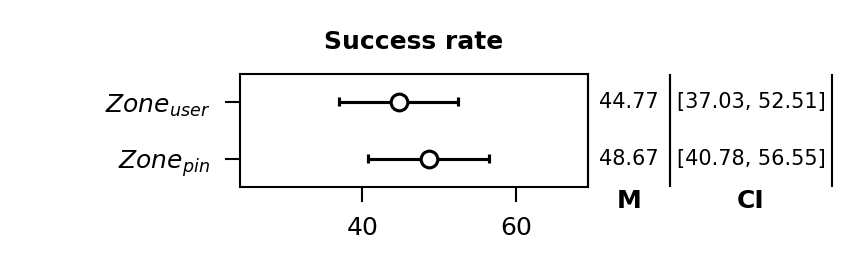

,index,variable,factor
0,0,100.0,USERO
1,1,100.0,USERO
2,2,100.0,USERO
3,3,100.0,SYSO
4,4,80.0,SYSO
...,...,...,...
260,260,0.0,USERO
261,261,0.0,SYSO
262,262,0.0,SYSO
263,263,0.0,SYSO


,USERO,SYSO
count,132.000,133.000
mean,44.771,48.668
cil,37.110,41.130
cih,52.710,56.510


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,USERO|SYSO,133,False,Wilcoxon,2078.5,0.452,-0.088


In [18]:
from mystats import statistics
from IPython.display import display, HTML

df_task.reset_index(inplace=True, drop=True)

factor_values_labels_map = {
    'Task':{
        'values':['SYSI', 'USERI'],
        'labels':['Interrupt_{system}', 'Interrupt_{user}'],
        },
    'Modality':{
        'values':['SYSO', 'USERO'],
        'labels':['Zone_{pin}', 'Zone_{user}'],
        }
}

factor_names_list = [['Task', 'Modality']] #
variable_name_list = ['success_rate']
new_variable_name_list = ['Success rate']
filename_body_list = ['Success Rate']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # scope dataframe
        df_var = df_task.loc[::,factor_names + [variable_name]].reset_index()
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # # plotting figure
        # if len(factor_columns) == 1:
        #     fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
        #         df_var,
        #         figure_size = (2, 1),
        #         figure_dpi = 300,
        #         factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
        #         factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
        #         variable_column = 'variable',
        #         variable_label = new_variable_name_list[variable_index],
        #         variable_lim = new_variable_range_list[variable_index],
        #         )
        #     plt.show()

        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotQuantMonoFactor(
                df_var,
                figure_size = (1.5, 0.5),
                figure_dpi = 300,
                table_bbox = [1.0, -0.25, 0.7, 1.25],
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            # if PLOT_SAVING:
            #     filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
            #     fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotQuantDualFactors(
                df_var,
                figure_size = (1.5, 1),
                figure_dpi = 300,
                table_bbox = [1.0, -0.12, 0.7, 1.12],
                table_head_height = 0.5,
                table_row_height = 1,
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            # if PLOT_SAVING:
            #     filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
            #     fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()
        
        # descriptive statistics
        
        # Pivot factor x variables

        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        display(df_var_cpy)
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQuantPaired(df_var_pivot, normality_assumption = 'false').round(3)
        display(df_stats_infer)
